In [1]:
import networkx as nx
from sklearn.linear_model import LogisticRegression
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uuid
import itertools

In [2]:
class World:
    def __init__(self,  agents, init_edge_proba=0, agent_power=3):
        self.G=nx.Graph()
        
        for agent in agents:
            self.G.add_node(agent)
            
        for target in self.G.nodes:
            for other in self.G.nodes:
                if target != other and random.random() < init_edge_proba:
                    self.G.add_edge(target, other)
                    
        self.centrality_dict = nx.degree_centrality(self.G)
        self.history = {}
        self.step = 0
        self.agent_power = agent_power 
        
    def draw(self):
        
        ndict = dict(zip(self.G.nodes, [str(i.name) for i in self.G.nodes]))
        fig = plt.figure(figsize = (10,10))
        pos=nx.spring_layout(self.G)
        nx.draw(self.G, pos = pos)
        nx.draw_networkx_labels(self.G, pos=pos, labels=ndict)
        plt.plot()
        
    def edge_evaluation(self, pred_a, pred_b):
        return (pred_a+pred_b)/2*random.uniform(0,2) > 0.5
        
    def selection(self):
        pass
        
    def distribute_power(self, dictionary):
        distributed = [i*self.agent_power/sum(dictionary.values()) for i in dictionary.values()]
        return(dict(zip(dictionary.keys(), distributed)))
    
    def update_history(self, step, **kwargs):
        self.history[step] = self.G.copy()
        
    def iterate(self, iterations, verbose=0, draw=False):
        for iteration in range(iterations):
            self.update_history(step=self.step)
            for agent in self.G.nodes:
                agent.learn(self)
                agent.predict(self)
                agent.prediction_dict[self.step] = self.distribute_power(agent.predict(self))
                        
            for pair in itertools.combinations(self.G.nodes, 2):                
                if self.edge_evaluation(pair[0].prediction_dict[self.step][pair[1]],
                                        pair[1].prediction_dict[self.step][pair[0]]):
                    
                    if pair not in self.G.edges:
                        self.G.add_edge(*pair)
                        
                elif pair in self.G.edges:
                    self.G.remove_edge(*pair)
                
            if draw:
                self.draw()
                
            self.centrality_dict = nx.closeness_centrality(self.G)
            self.selection()
            self.step += 1

In [3]:
class selectiveWorld(World):
    def __init__(self,  agents, init_edge_proba=0, agent_power=3, min_degs=1, selection_proba=0.2):
        World.__init__(self,  agents=agents, init_edge_proba=init_edge_proba, agent_power=agent_power)
        self.min_degs = min_degs
        self.selection_proba = selection_proba
    def selection(self):
        for node in list(self.G.nodes):
            if self.G.degree(node) < self.min_degs and random.random() < self.selection_proba:
                self.G.remove_node(node)
                
        

In [ ]:
isupper('a')

In [4]:
class AgentSkeleton:
    def __init__(self, name=None):
        self.prediction_dict = {}
         
        if name is None:
            self.name = '{}-{}'.format(''.join([i for i in self.__class__.__name__ if i.isupper() or i.isdigit()]), 
                                       str(uuid.uuid4())[:8])
        else: 
            self.name = name
            
    def learn(self, world):
        pass
    
    def predict(self, world):
        return dict(zip(list(world.G.nodes), [random.random() for i in world.G.nodes]))
    
    def calculate_embeddedness(self, world):
        return world.centrality_dict[self]       
    

In [5]:
class GetBasedonDegree_v1(AgentSkeleton):
    def predict(self, world):
        if sum(world.centrality_dict.values()) > 0:
            return world.centrality_dict
        else:
            return dict(zip(list(world.G.nodes), [random.random() for i in world.G.nodes]))

In [6]:
class GetBasedonDegree_v2(AgentSkeleton):
    def predict(self, world):
        if sum(world.centrality_dict.values()) > 0:
            return world.centrality_dict
        else:
            chosen = random.sample(list(world.G.nodes), world.agent_power)
            return dict(zip(list(world.G.nodes), [1 if i in chosen else 0 for i in list(world.G.nodes)]))

In [7]:
class GetBasedonDegree_V3(AgentSkeleton):
    def predict(self, world):
        if sum(world.centrality_dict.values()) > 0:
            res = world.centrality_dict.copy()
            for key in res.keys():
                res[key] += 0.1
            return res
        else:
            return dict(zip(list(world.G.nodes), [random.random() for i in world.G.nodes]))

In [8]:
GetBasedonDegree_v1().name

'GBD1-6cb69108'

In [ ]:
for n in range(len(test_world.history)):
    learn_df = pd.DataFrame()
    #learn_df['TARGET'] = pd.Series(other.prediction_dict[n])
    learn_df['DEGREE'] = pd.Series(dict(test_world.history[n].degree()))
    learn_df['DEGREE_CENTRALITY'] = pd.Series(nx.degree_centrality(test_world.history[n]))
    learn_df['CLOSENESS_CENTRALITY'] = pd.Series(nx.closeness_centrality(test_world.history[n]))
    plt.scatter(learn_df['DEGREE_CENTRALITY'], learn_df['CLOSENESS_CENTRALITY'])
    plt.show()

In [ ]:
type(GetBasedOnDegree)

C:\Users\bmucs\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


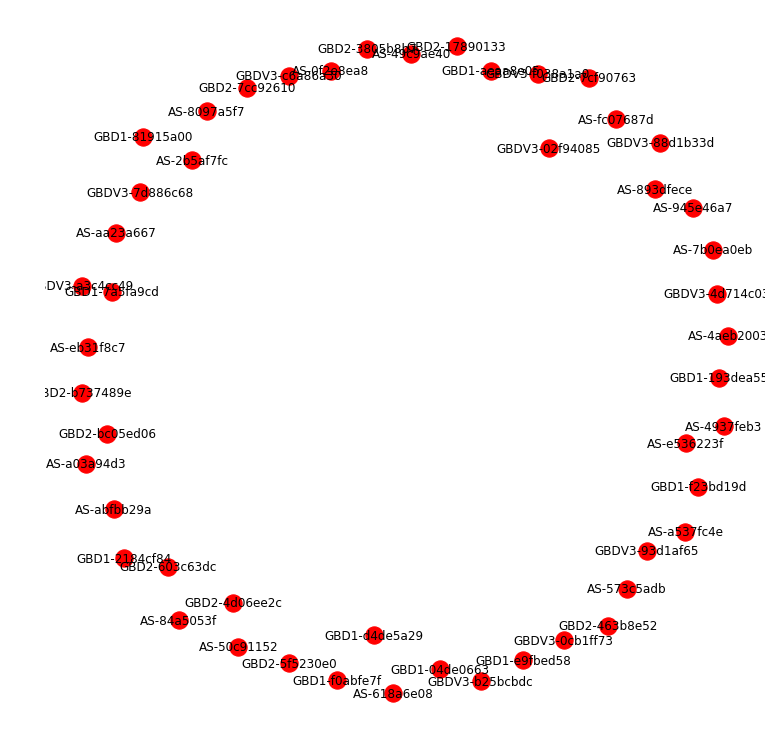

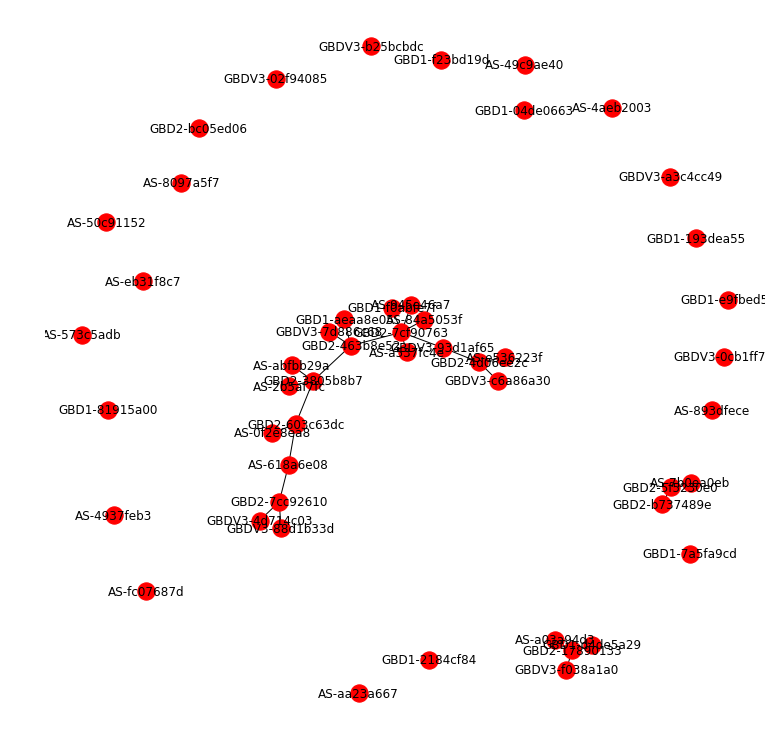

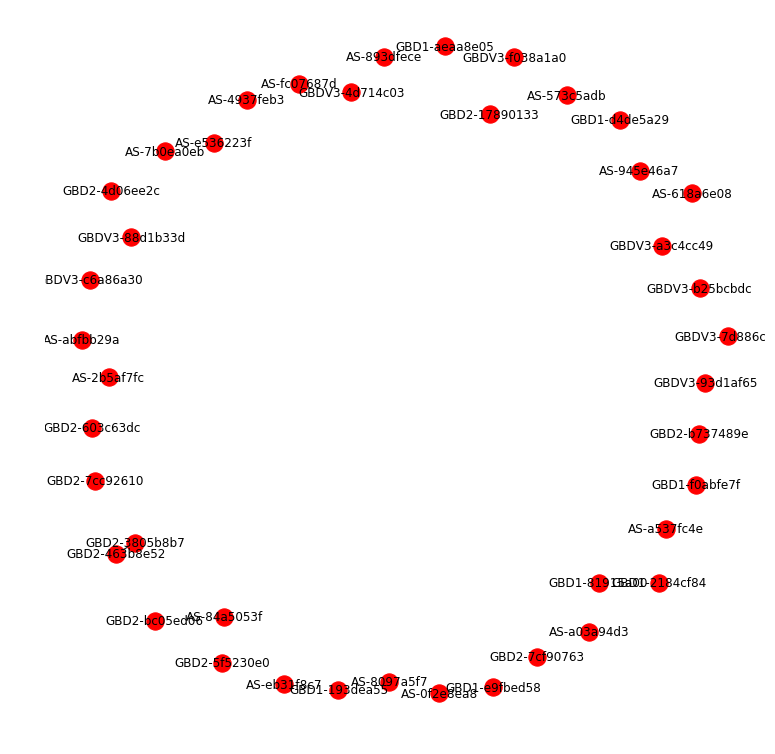

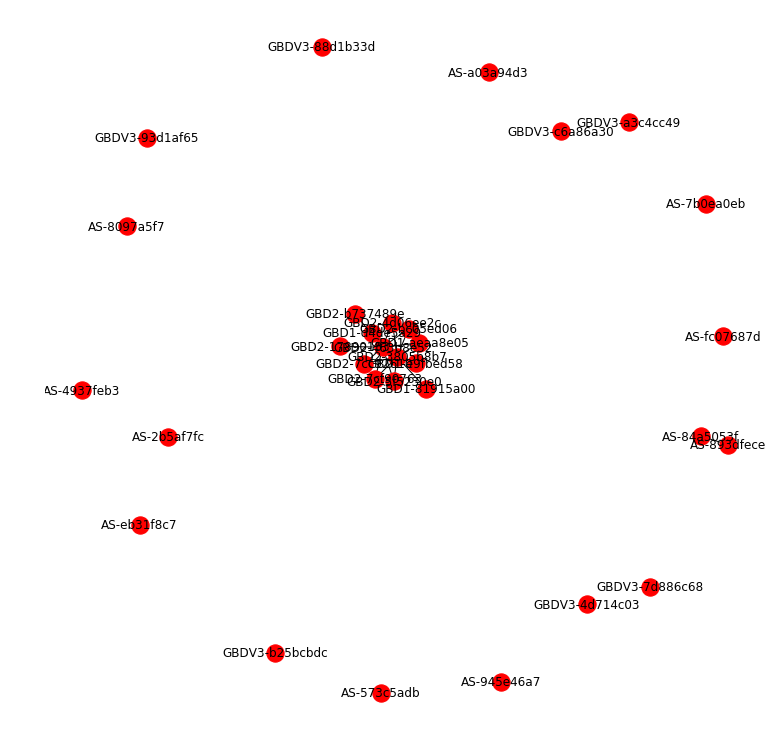

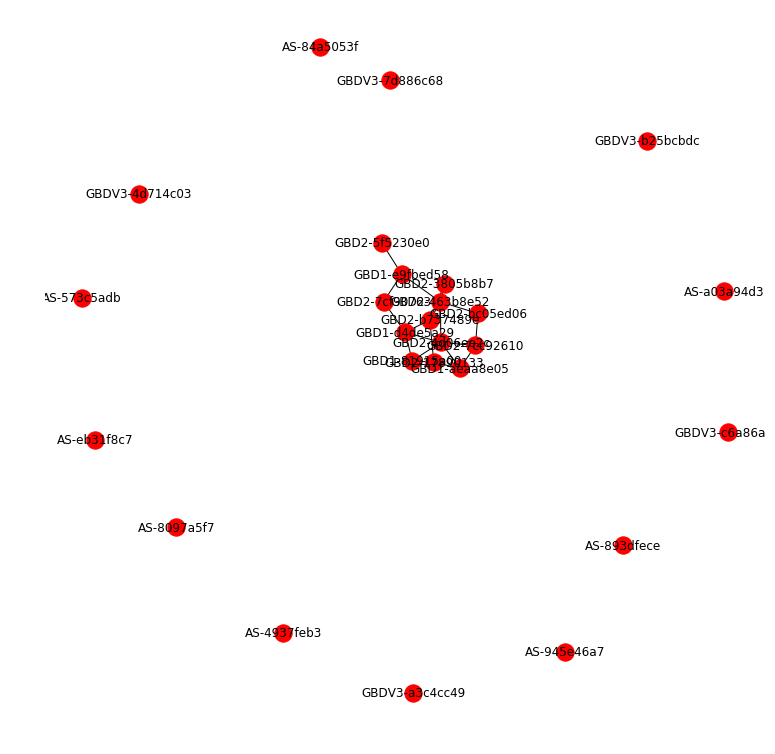

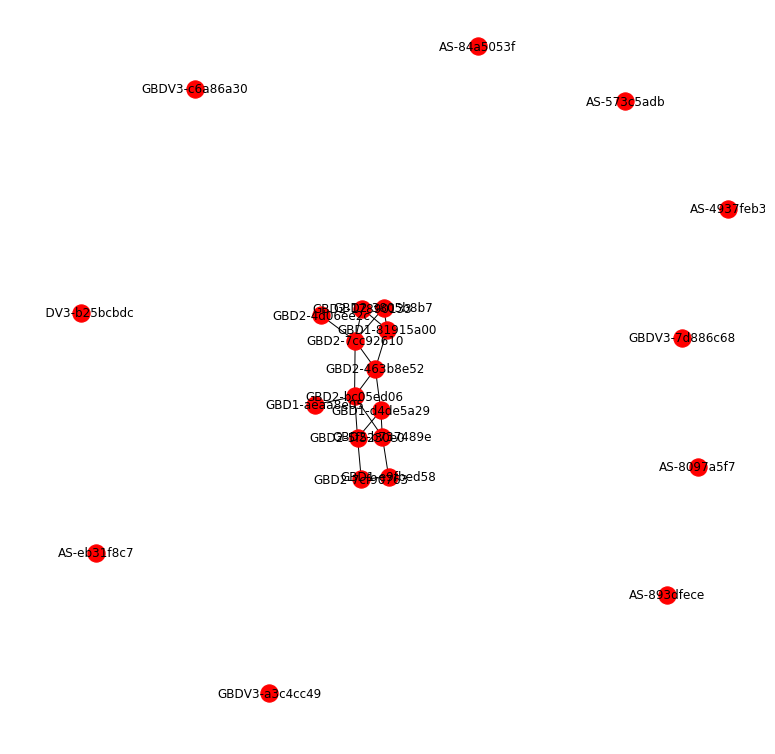

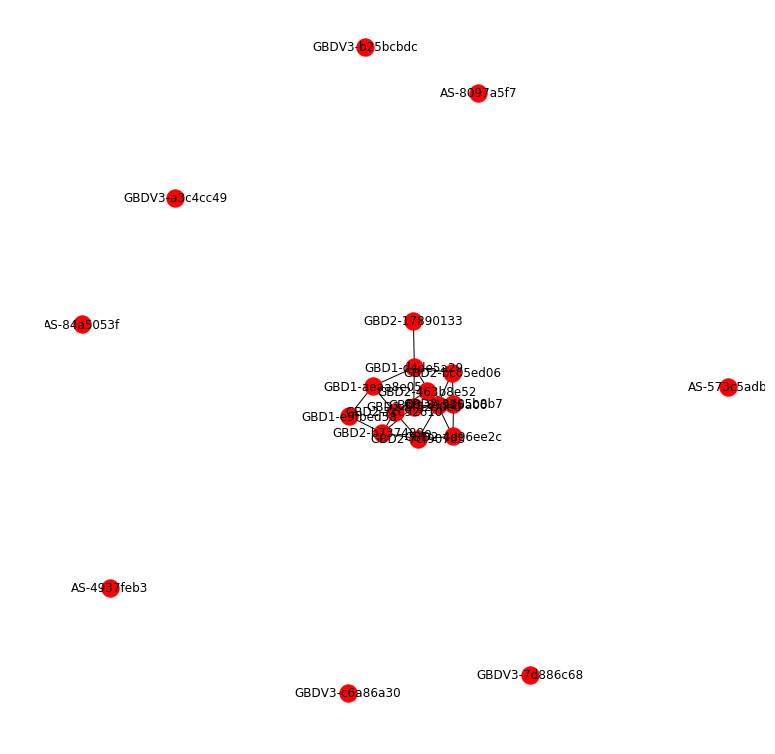

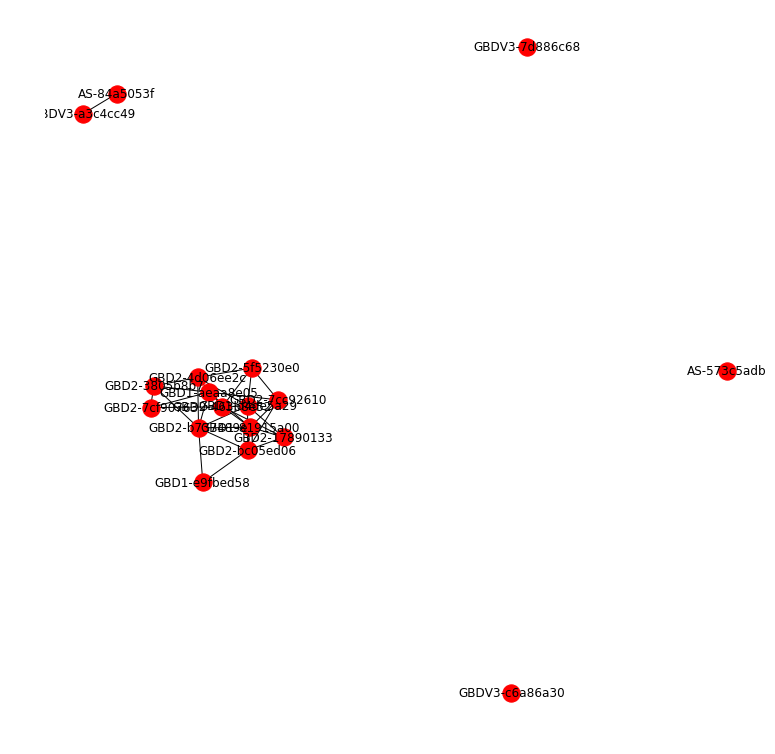

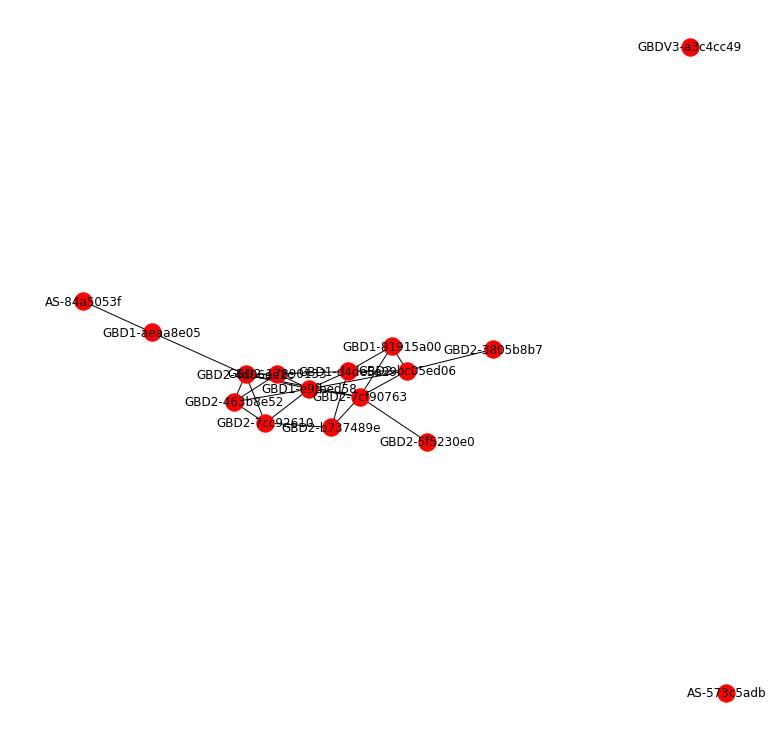

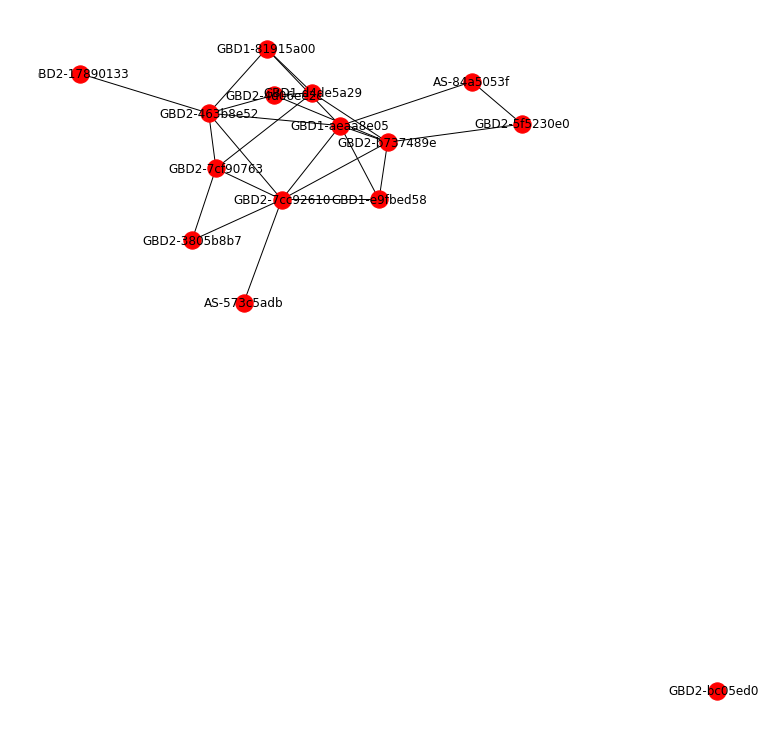

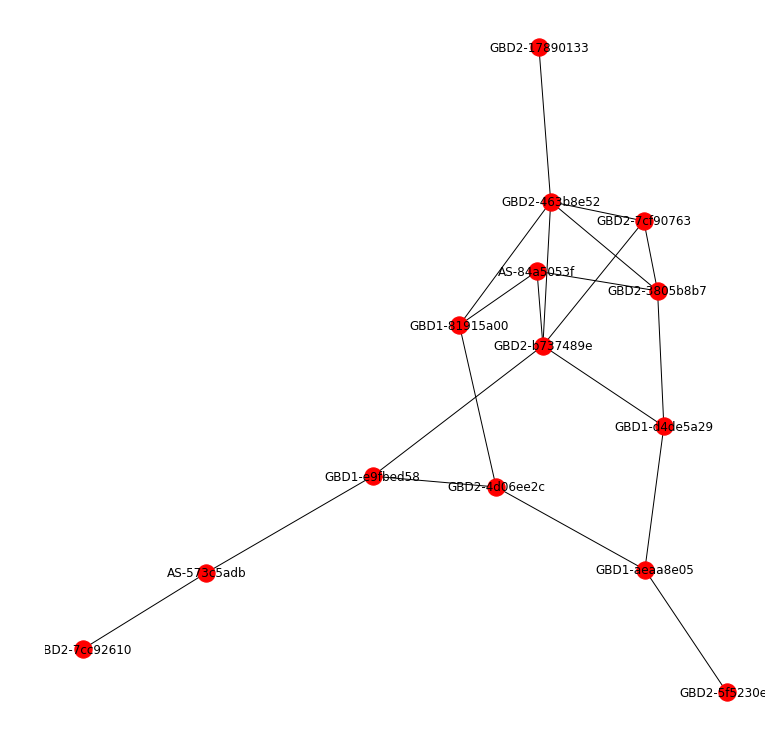

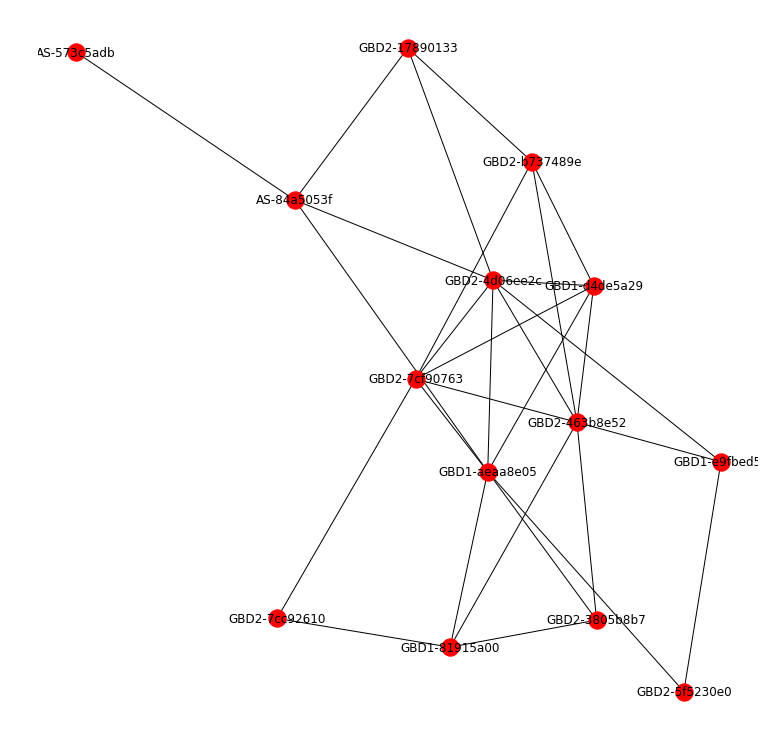

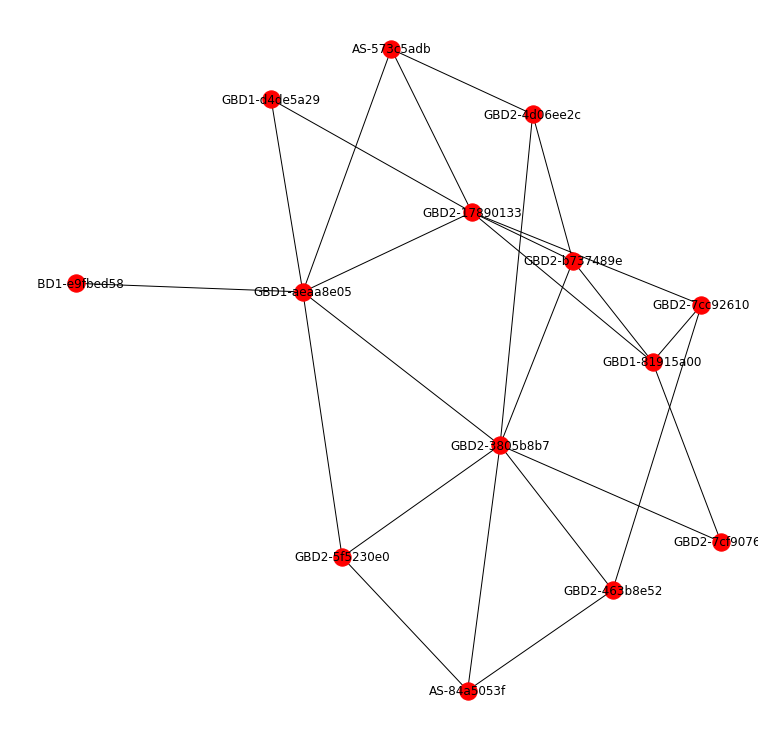

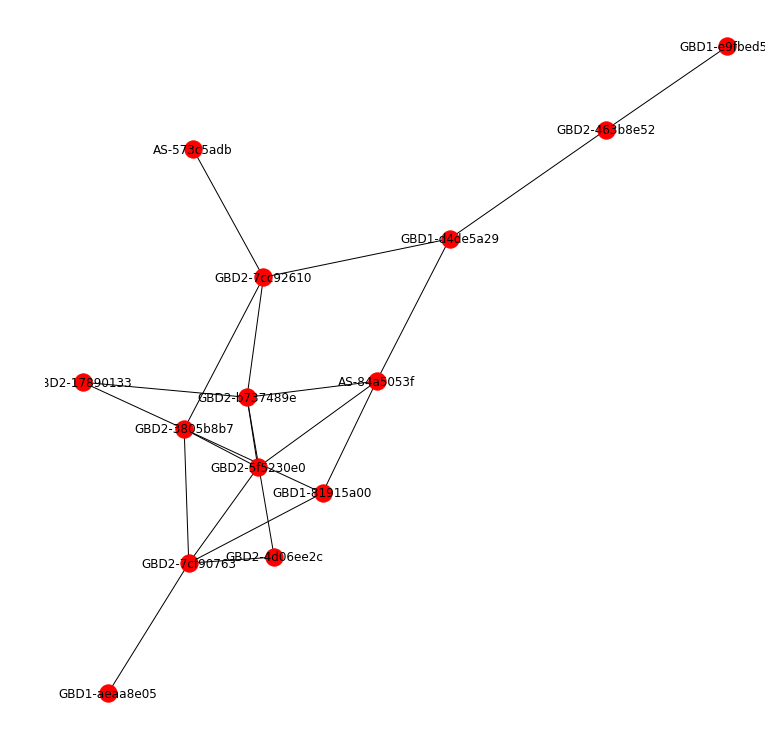

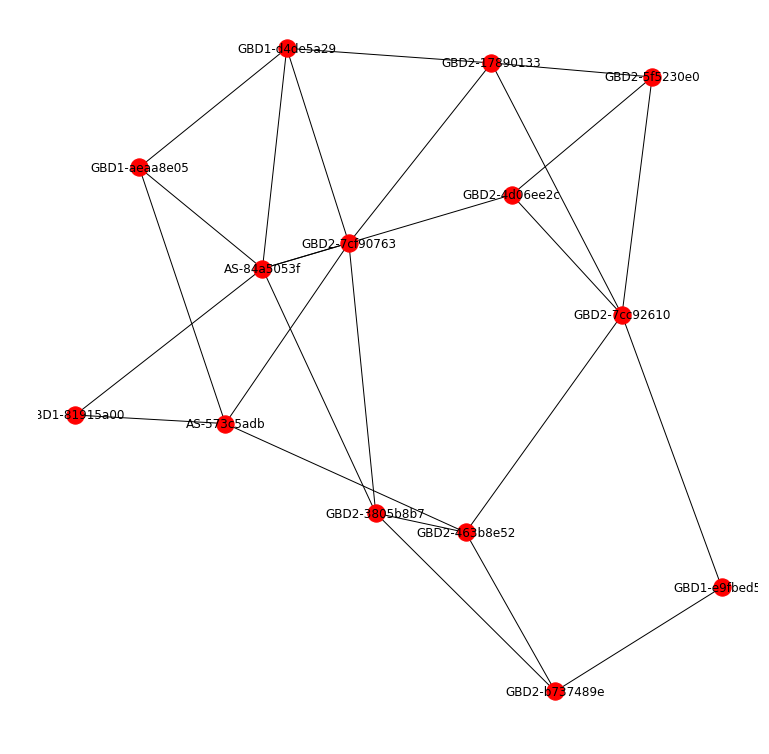

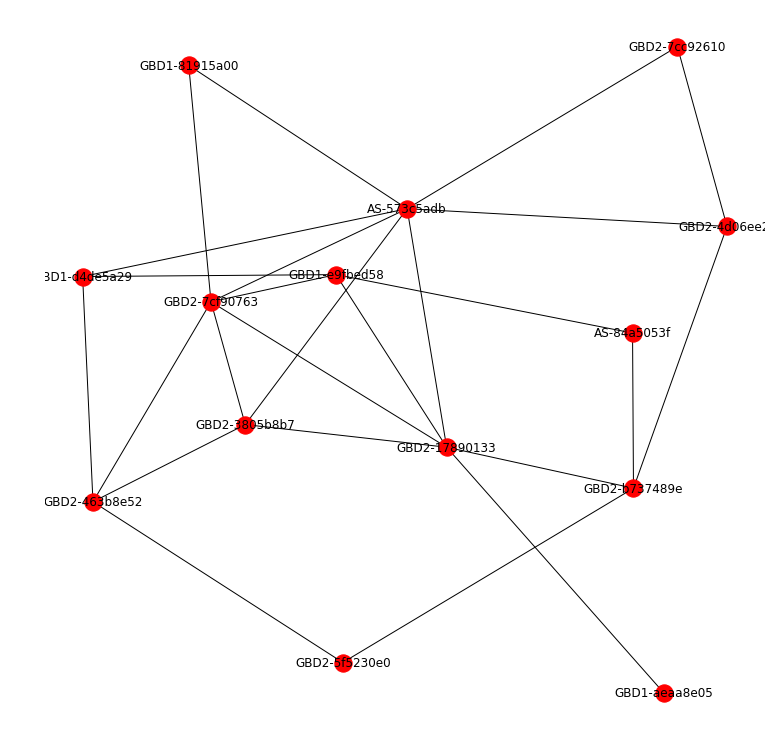

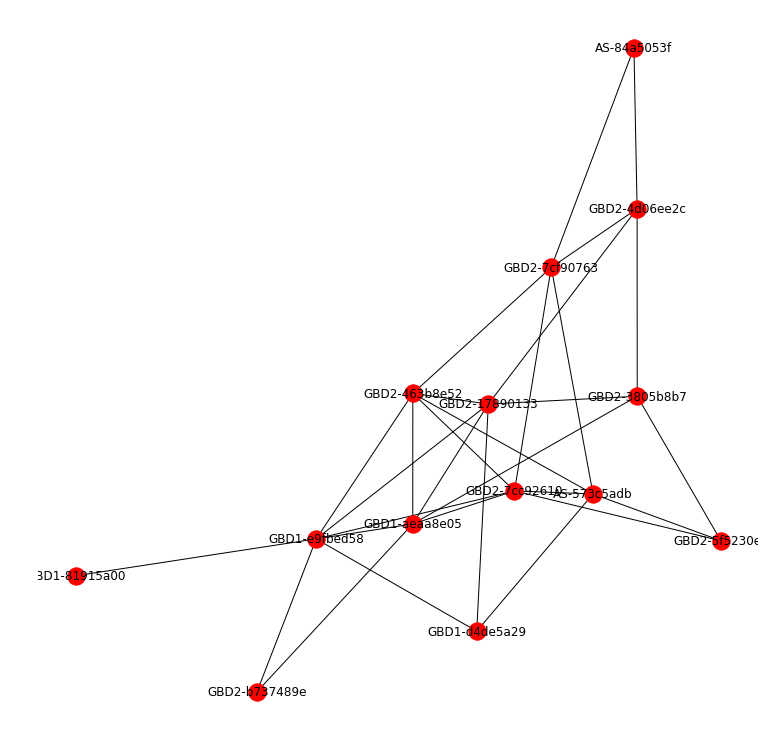

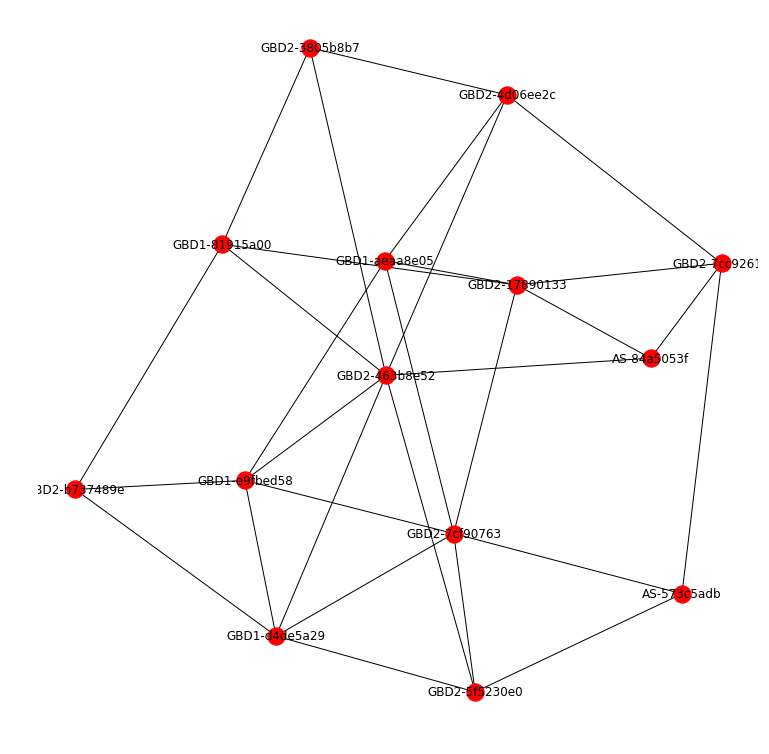

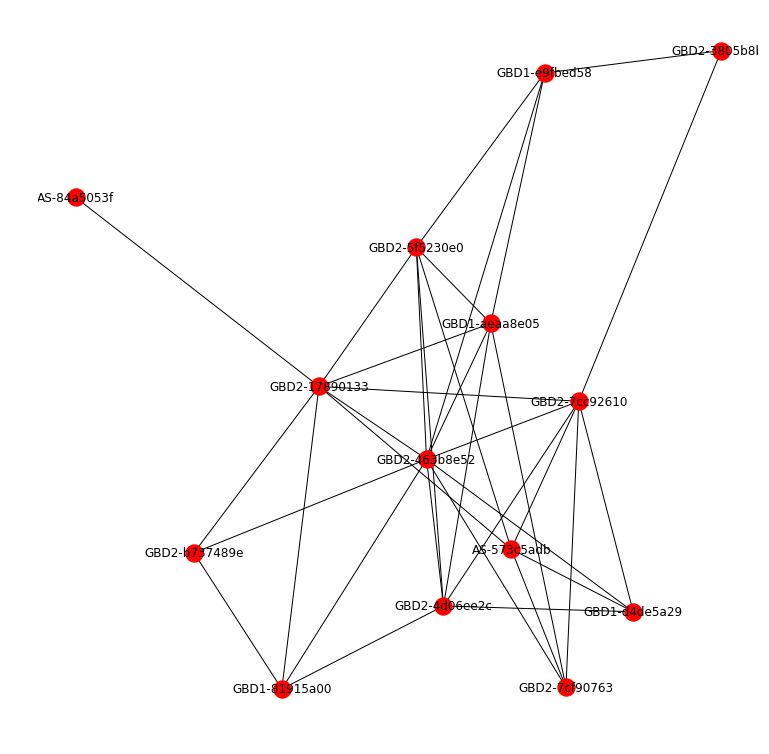

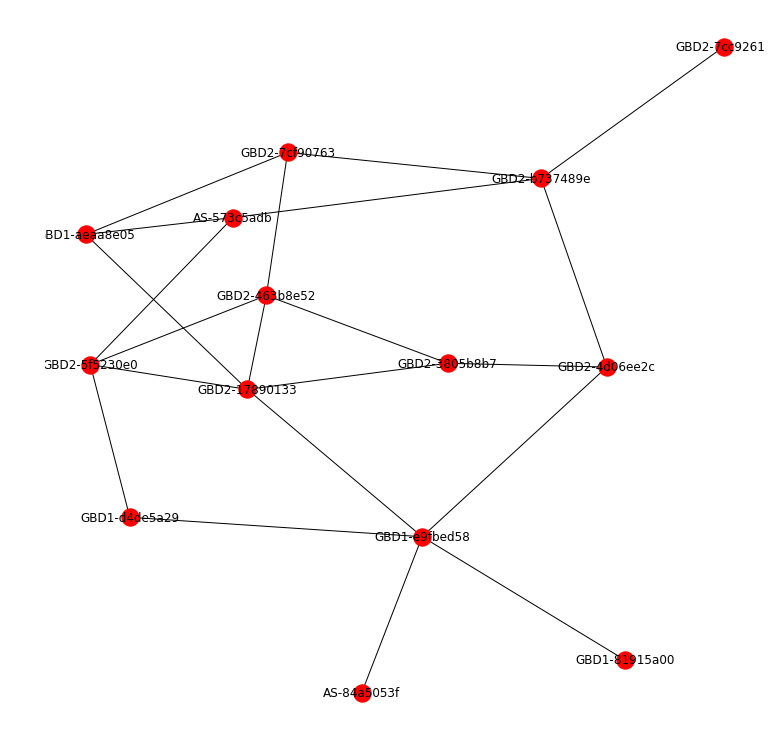

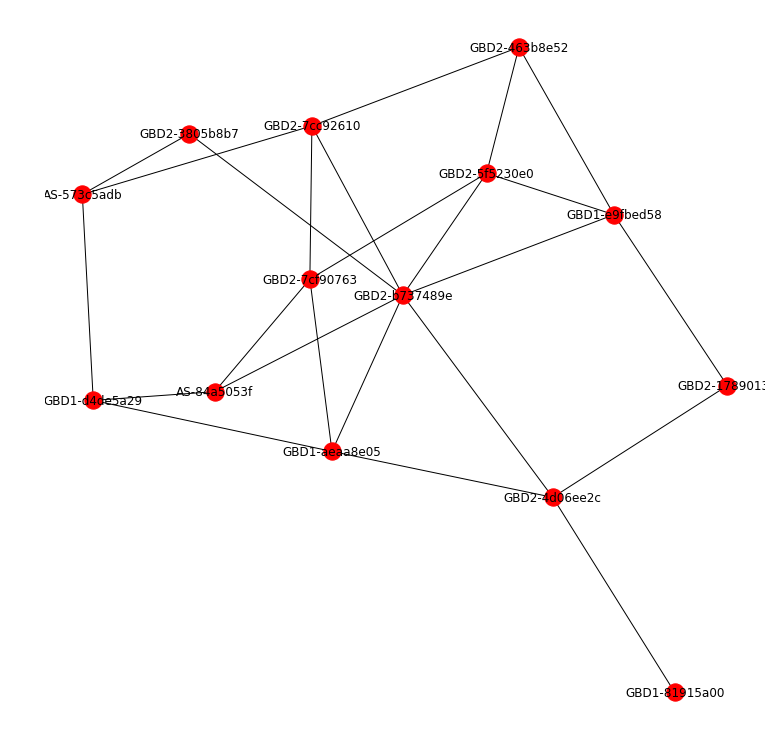

In [17]:
agents = []
agents += [GetBasedonDegree_V3() for i in range(10)] 
agents += [GetBasedonDegree_v2() for i in range(10)] 
agents += [GetBasedonDegree_v1() for i in range(10)] 
agents += [AgentSkeleton() for i in range(20)] 
test_world = selectiveWorld(agents, agent_power=5, min_degs=1, selection_proba = 0.3)
test_world.draw()
test_world.iterate(20, draw = True)

In [ ]:
agents = []
#agents += [GetBasedOnDegree_V3(name='D{}'.format(i)) for i in range(50)] 
#agents += [GetBasedOnDegree_v2(name='D{}'.format(i)) for i in range(50)] 
agents += [GetBasedOnDegree(name='D{}'.format(i)) for i in range(40)] 
agents += [AgentSkeleton(name='A{}'.format(i)) for i in range(10)] 
print(agents)
test_world = selectiveWorld(agents, agent_power=5, min_degs=1, selection_proba = 0.1)
test_world.draw()
test_world.iterate(10, draw = True)

In [ ]:
agents = []
#agents += [GetBasedOnDegree_V3(name='A{}'.format(i)) for i in range(50)] 
#agents += [GetBasedOnDegree_v2(name='D{}'.format(i)) for i in range(50)] 
agents += [GetBasedOnDegree(name='A{}'.format(i)) for i in range(50)] 
#agents += [AgentSkeleton(name='A{}'.format(i)) for i in range(30)] 
print(agents)
test_world = selectiveWorld(agents, agent_power=5, min_degs=1, selection_proba = 0.3)
test_world.draw()
test_world.iterate(50, draw = True)

In [ ]:
agents = []
#agents += [GetBasedOnDegree_V3(name='A{}'.format(i)) for i in range(50)] 
#agents += [GetBasedOnDegree_v2(name='D{}'.format(i)) for i in range(50)] 
#agents += [GetBasedOnDegree(name='A{}'.format(i)) for i in range(45)]
agents += [AgentSkeleton(name='A{}'.format(i)) for i in range(50)] 
print(agents)
test_world = selectiveWorld(agents, agent_power=5, min_degs=1, selection_proba = 0.3)
test_world.draw()
test_world.iterate(50, draw = True)

In [ ]:
agents = []
agents += [GetBasedOnDegree_V3(name='D{}'.format(i)) for i in range(30)] 
#agents += [GetBasedOnDegree_v2(name='D{}'.format(i)) for i in range(50)] 
#agents += [GetBasedOnDegree(name='D{}'.format(i)) for i in range(30)]
agents += [AgentSkeleton(name='A{}'.format(i)) for i in range(20)] 
print(agents)
test_world = selectiveWorld(agents, agent_power=5, min_degs=1, selection_proba = 0.3)
test_world.draw()
test_world.iterate(50, draw = True)